### Importing libraries

In [13]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
from matplotlib.patches import Patch, PathPatch
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics
from enum import auto

### Loading affected protein block summary table

In [16]:
# GENCODE toy
pblocks = pd.read_csv('../B_hybrid_aln_results_toy/pblocks.tsv', sep='\t')

In [21]:
# GENCODE v41
pblocks = pd.read_csv('../B_hybrid_aln_gencode_v41/pblocks.tsv', sep='\t')

In [27]:
# WTC11
pblocks = pd.read_csv('../B_hybrid_aln_wtc11/pblocks.tsv', sep='\t')

In [28]:
class NTerminalChange():
    MUTUALLY_EXCLUSIVE = auto()
    DOWNSTREAM_SHARED = auto()
    UPSTREAM_SHARED = auto()
    MUTUALLY_SHARED = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

class CTerminalChange():
    SPLICING = auto()
    FRAMESHIFT = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

In [29]:
nterm_pblocks = pblocks[~pblocks['nterm'].isna() & (pblocks['nterm'] != NTerminalChange.ALTERNATIVE_ORF) & (pblocks['cterm'] != CTerminalChange.ALTERNATIVE_ORF)].copy()
nterm_pblocks['nterm'] = nterm_pblocks['nterm'].astype('category')
# Changed string to set for intersection
nterm_pblocks['altTSS'] = nterm_pblocks['events'].apply(lambda x: set(x).intersection('BbPp')).astype(bool)

display(pd.crosstab(nterm_pblocks['up_start_cblock_category'], nterm_pblocks['down_start_cblock_category'], margins=True))

down_start_cblock_category,-,DELETION,FRAME_AHEAD,FRAME_BEHIND,INSERTION,MATCH,TRANSLATED,UNTRANSLATED,All
up_start_cblock_category,,,,,,,,,
DELETION,5586,0,54,282,1348,0,416,0,7686
INSERTION,942,1083,27,26,0,0,0,159,2237
MATCH,0,0,0,0,0,12,0,0,12
TRANSLATED,318,274,55,28,0,0,0,143,818
UNTRANSLATED,402,0,7,34,176,0,5,0,624
All,7248,1357,143,370,1524,12,421,302,11377


### Plot 1: Alternative N-termini categorization based on exclusive or shared nature of start codons between transcripts

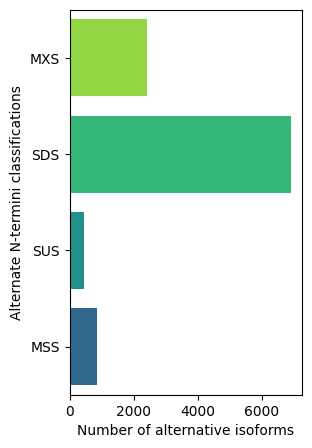

In [30]:
nterm_palette = dict(zip(("MUTUALLY_EXCLUSIVE", "DOWNSTREAM_SHARED", "UPSTREAM_SHARED", "MUTUALLY_SHARED"), sns.color_palette('viridis_r', n_colors=5)[:-1]))

nterm_fig = plt.figure(figsize=(3, 5))
ax = sns.countplot(
    data = nterm_pblocks,
    y = 'nterm',
    order = ("MUTUALLY_EXCLUSIVE", "DOWNSTREAM_SHARED", "UPSTREAM_SHARED", "MUTUALLY_SHARED"),
    palette = nterm_palette,
    linewidth = 0,
    saturation = 1,
)
ax.set(xlabel='Number of alternative isoforms', ylabel='Alternate N-termini classifications', yticklabels=['MXS', 'SDS', 'SUS', 'MSS']) 

plt.savefig('../D_nterm_plots/nterm-class-counts.svg', dpi=200, facecolor=None)

### Plot 2: Distribution of the change in N-terminal length across diffrent alternative N-termini categories

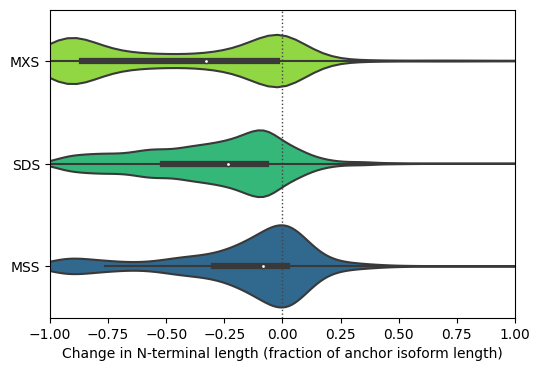

In [31]:
nterm_length_order = ("MUTUALLY_EXCLUSIVE", "DOWNSTREAM_SHARED", "MUTUALLY_SHARED")

nterm_length_fig = plt.figure(figsize=(6, 4))
ax = sns.violinplot(
    data = nterm_pblocks,
    x = 'anchor_relative_length_change',
    y = 'nterm',
    order = nterm_length_order,
    gridsize = 200,
    palette = nterm_palette,
    saturation = 1,
    scale = 'area',
)

xmax = max(ax.get_xlim())
ymin, ymax = ax.get_ylim()
ax.vlines(x=0, ymin=ymin, ymax=ymax, color='#444444', linewidth=1, linestyle=':')
ax.set(xlim=(-1, 1), ylim=(ymin, ymax), xlabel='Change in N-terminal length (fraction of anchor isoform length)', ylabel=None, yticklabels=['MXS', 'SDS', 'MSS'])
plt.savefig('../D_nterm_plots/nterm-length-change-dist.svg', dpi=200, facecolor=None)

### Plot 3: Alternative N-termini categorization based on insertion and/or deletion nature of "involved start codon"(this could use a name).

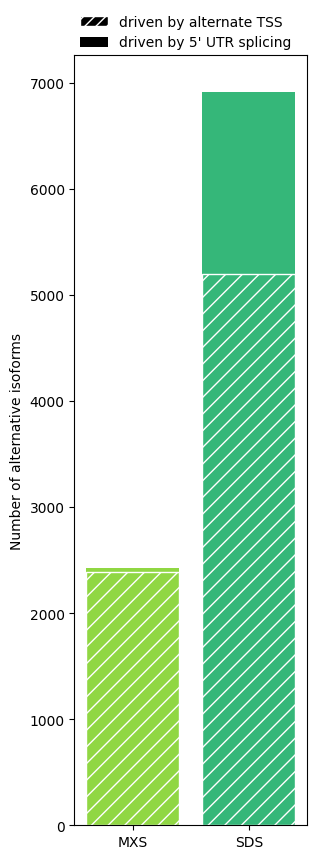

In [32]:
tss_fig = plt.figure(figsize=(3, 10)) # Added height
ax = sns.countplot(
    data = nterm_pblocks,
    x = 'nterm',
    palette = nterm_palette,
    saturation = 1,
    order = ("MUTUALLY_EXCLUSIVE", "DOWNSTREAM_SHARED"),
)
sns.countplot(
    ax = ax,
    data = nterm_pblocks[nterm_pblocks['altTSS']],
    x = 'nterm',
    order = ("MUTUALLY_EXCLUSIVE", "DOWNSTREAM_SHARED"),
    fill = False,
    edgecolor = 'w',
    hatch = '//',
)
ax.legend(loc=(0, 1), frameon=False, handles=[Patch(facecolor='k', edgecolor='w', hatch='///'), Patch(facecolor='k')], labels=['driven by alternate TSS', 'driven by 5\' UTR splicing'])
ax.set(ylabel='Number of alternative isoforms', xlabel=None, xticklabels=['MXS', 'SDS'])
plt.savefig('../D_nterm_plots/nterm-altTSS-counts.svg', dpi=200, facecolor=None)
